In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flg-library/')
import flg_support as fls
import flg_unet
import flg_numerics
import flg_model
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

In [2]:
all_data = fls.load_all_train_data()
np.random.default_rng(seed=0).shuffle(all_data)

# Pick N tomograms with 1 motor and N tomograms with 0 motors as validation set
N=100
n_motors = np.array([len(d.labels) for d in all_data])
inds_zero = np.argwhere(n_motors==0)[:N,0]
inds_one = np.argwhere(n_motors==1)[:N,0]
inds_test = np.concatenate((inds_zero,inds_one))
inds_train = np.setdiff1d(np.arange(len(n_motors)), inds_test)
inds_test.shape, inds_train.shape

train_data = []
for i in inds_train:
    train_data.append(all_data[i])
test_data = []
for i in inds_test:
    test_data.append(all_data[i])
np.random.default_rng(seed=0).shuffle(test_data)
test_data = test_data
len(train_data), len(test_data)

(444, 200)

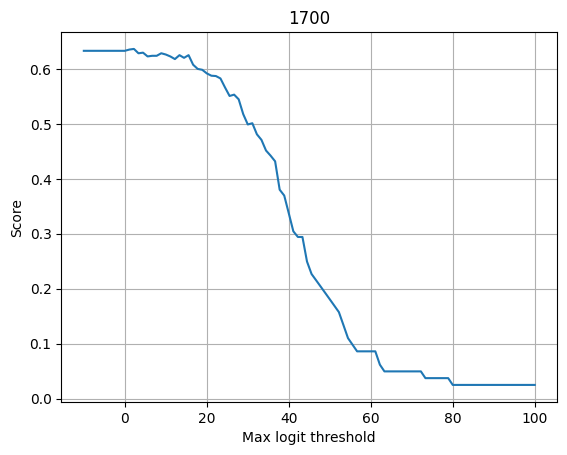

In [3]:
for ii in [500,1000,1500,1700]:
    model = flg_model.ThreeStepModel()
    model.step1Heatmap.model = fls.dill_load(fls.temp_dir + 'intermediate_model_' +str(ii) + '.pickle')
    model.train(train_data, test_data)
    fls.dill_save(fls.model_dir + 'model_tuned_' + str(ii) + '.pickle', model)
    plt.title(str(ii))
    plt.pause(0.1)

In [5]:
inferred_test_data = model.infer(test_data)

In [6]:
print(fls.score_competition_metric(inferred_test_data, test_data))

0.6363636363636364


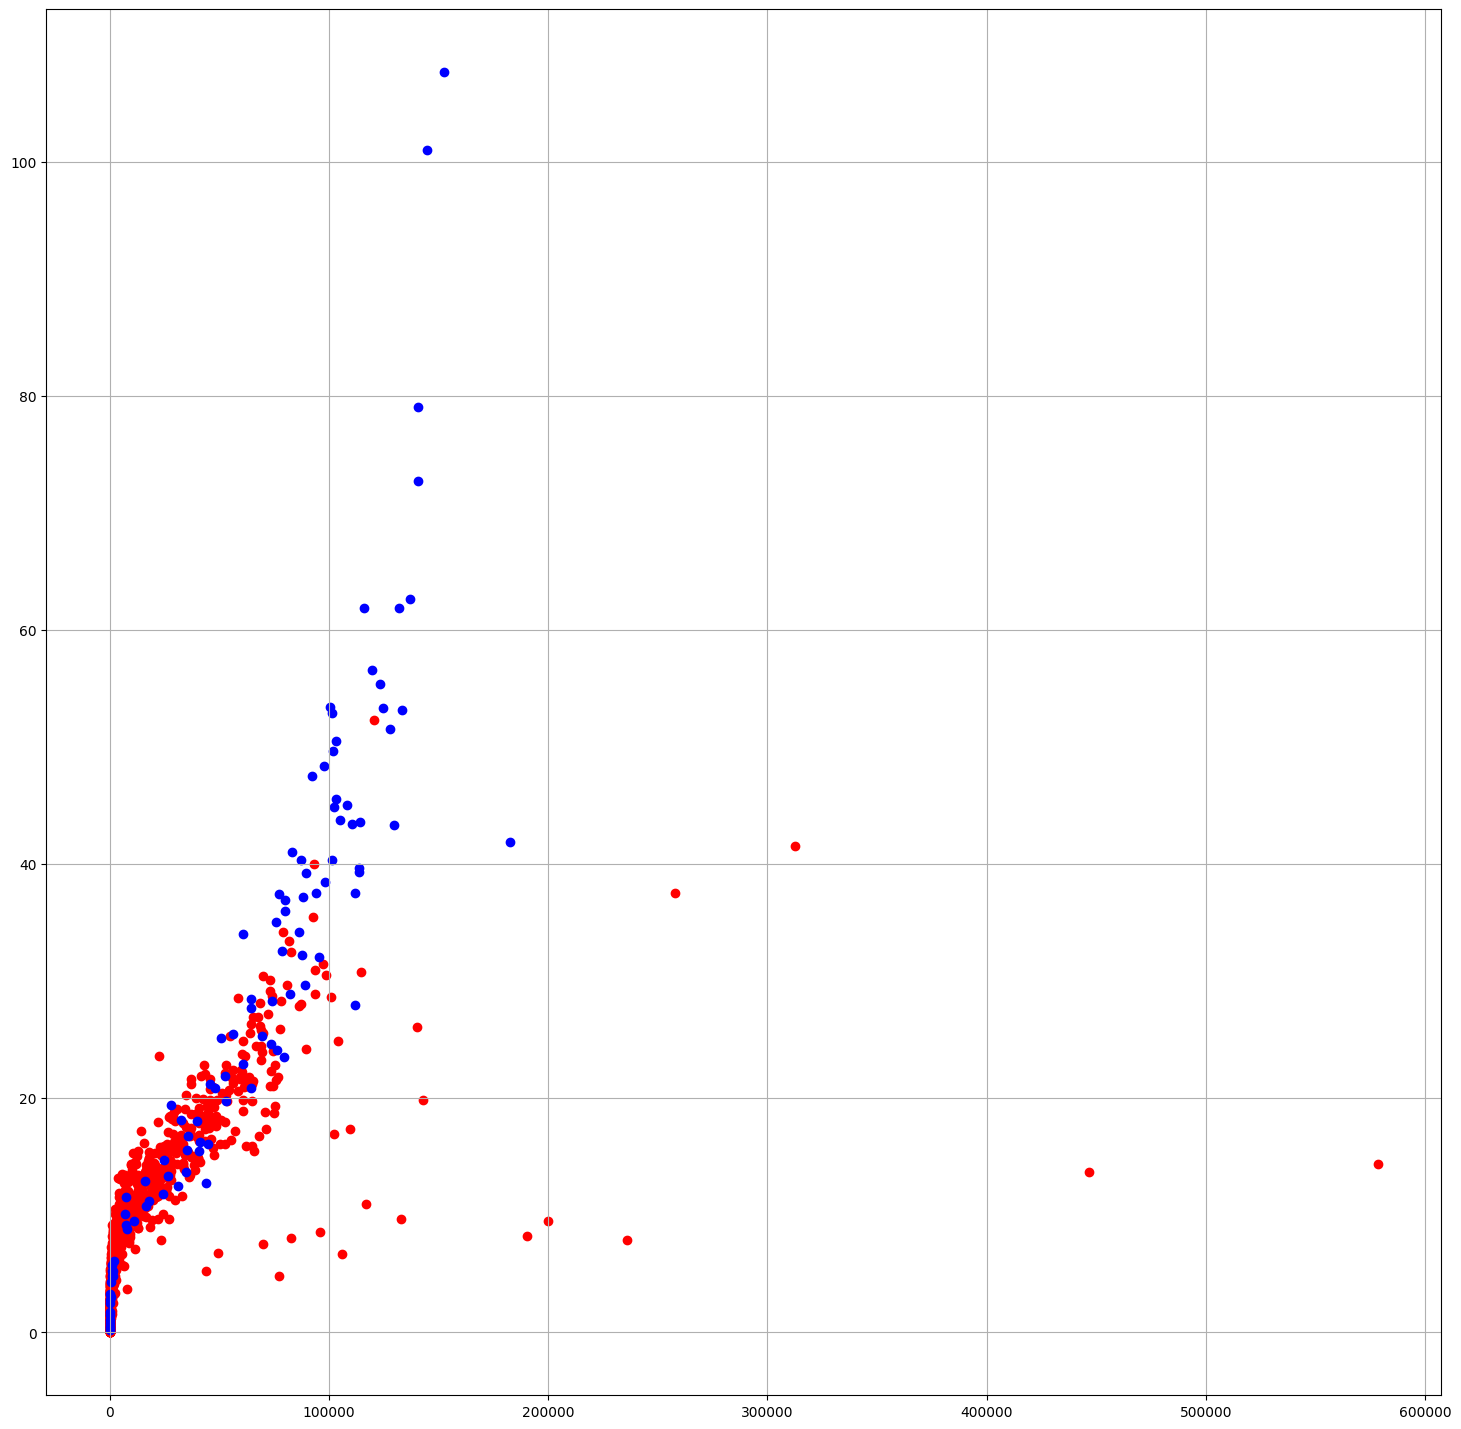

In [8]:
fls.mark_tf_pn(inferred_test_data, test_data)
cs_tp = []
cs_fp = []
log_tp = []
log_fp = []
for t in inferred_test_data:
    for d in range(len(t.labels_unfiltered)):
        #print( t.labels_unfiltered['tf_pn']
        if t.labels_unfiltered['tf_pn'][d]==0:
            cs_tp.append(t.labels_unfiltered['size'][d])
            log_tp.append(t.labels_unfiltered['max_logit'][d])
        if t.labels_unfiltered['tf_pn'][d]==1:
            cs_fp.append(t.labels_unfiltered['size'][d])
            log_fp.append(t.labels_unfiltered['max_logit'][d])
plt.figure(figsize=(18,18))
plt.scatter(cs_fp, log_fp, color='red')
plt.scatter(cs_tp, log_tp, color='blue')
plt.grid(True)